In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


import numpy as np
import matplotlib.pyplot as plt
import scipy

#from google.colab import runtime


In [2]:
#Hyperparameters
lr = 0.00005
momentum = 0 #default = 0
weight_decay = 0.05 #default = 0
dampening = 0 #default = 0

#Other
batch_size = 16
epochs = 100

In [3]:
transforms = {
    'train':
    #Composing several transforms together
    transforms.Compose(
        [
            transforms.RandomRotation(degrees=15),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(),
            transforms.GaussianBlur(1),
            transforms.RandomAdjustSharpness(1),
            transforms.RandomPerspective(),
            transforms.ToTensor(), #To tensor object
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #Mean = 0.5, std = 0.5
            transforms.Resize((256,256)) #Speeds up model without losing too much information
        ]),

    'trainOld':
    transforms.Compose(
        [
            transforms.TrivialAugmentWide(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((256,256)),
        ]
    ),

    'val':
    transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((256,256))
        ]),

    'test':
    transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((256,256))
        ])
}

In [4]:
train_data = datasets.Flowers102(root='./data', split='train', transform=transforms['train'], download=True)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

100%|██████████| 344862509/344862509 [00:10<00:00, 32155929.91it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 810758.80it/s]


100%|██████████| 14989/14989 [00:00<00:00, 15461982.95it/s]


In [5]:
val_data = datasets.Flowers102(root='./data', split='val', transform=transforms['val'], download=False)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [6]:
test_data = datasets.Flowers102(root='./data', split='test', transform=transforms['test'], download=False)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [7]:
#dataloaders = {
#    'train': train_dataloader,
#    'val': val_dataloader
#}

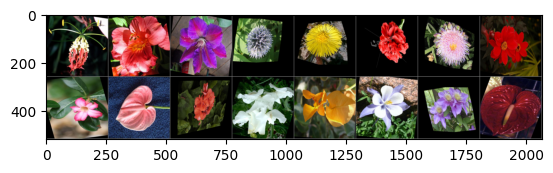

In [8]:
# Show the images in the batch to see what the transforms are doing to them
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(train_dataloader)
for i in range(1):
  images, lbls = next(dataiter)
  imshow(torchvision.utils.make_grid(images))

In [9]:
#Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [10]:
#Architecture inspired by https://poloclub.github.io/cnn-explainer/#article-input
#and PyTorch for Deep Learning & Machine Learning – Full Course by freeCodeCamp.org https://www.youtube.com/watch?v=V_xro1bcAuA
class CNNv3(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    #Block is comprised of multiple layers
    self.convLayer1 = self.ConvLayers(input_shape, hidden_units)
    self.convLayer2 = self.ConvLayers(hidden_units, hidden_units)
    self.convLayer3 = self.ConvLayers(hidden_units, hidden_units)
    self.convLayer4 = self.ConvLayers(hidden_units, hidden_units)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=1024),
        nn.ReLU(),
        nn.Linear(in_features=1024,
                  out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512,
                  out_features=output_shape)

    )

  def ConvLayers(self, input_shape, hidden_units):
    return nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

  def forward(self, x):
    x = self.convLayer1(x)
    #print(x.shape)
    x = self.convLayer2(x)
    #print(x.shape)
    x = self.convLayer3(x)
    #print(x.shape)
    x = self.convLayer4(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x

In [11]:
model = CNNv3(input_shape=3,
              hidden_units=102,
              output_shape=102).to(device)
print(model)

CNNv3(
  (convLayer1): Sequential(
    (0): Conv2d(3, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convLayer2): Sequential(
    (0): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convLayer3): Sequential(
   

In [12]:
#Loss function and optimiser
loss_fn = nn.CrossEntropyLoss()
#optimiser = torch.optim.SGD(model.parameters(),
#                            lr=lr,
#                            momentum=momentum,
#                            weight_decay=weight_decay,
#                            dampening=dampening)
optimiser = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)


In [13]:
#Train the model using the training data
def train(dataloader, model, loss_fn, optimiser):
  size = len(dataloader.dataset)
  batches = len(dataloader)
  model.train()
  running_loss, running_corrects = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    running_loss += loss.item()
    running_corrects += torch.count_nonzero(pred.argmax(1)==y).item()

    # Backpropagation
    loss.backward()
    optimiser.step()
    optimiser.zero_grad()

  ave_loss = running_loss/batches
  corrects = running_corrects/size

  print(f"Train Error: \nAccuracy: {(100*corrects):.2f}%, Avg loss: {ave_loss:.6f} \n")
  return ave_loss, corrects


In [14]:
#Validate the models progress using the validation data
def valTest(dataloader, model, loss_fn, split):
  size = len(dataloader.dataset)
  batches = len(dataloader)
  model.eval()
  running_loss, running_corrects = 0, 0

  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      loss = loss_fn(pred,y)

      running_loss += loss.item()
      running_corrects += torch.count_nonzero(pred.argmax(1)==y).item()

  ave_loss = running_loss/batches
  corrects = running_corrects/size

  print(f"{split} Error: \n Accuracy: {(100*corrects):.2f}%, Avg loss: {ave_loss:.6f} \n")

  return ave_loss, corrects


In [2]:
def pltHist(hist):
  plt.figure(figsize=(17,5))
  plt.subplot(121)
  plt.plot(hist['train_loss'],'-o')
  plt.plot(hist['val_loss'],'-o')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Train','Val'])
  plt.title('Train vs Validation loss')

  plt.subplot(122)
  plt.plot(hist['train_accuracy'],'-o')
  plt.plot(hist['val_accuracy'],'-o')
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Val'])
  plt.title('Train vs Validation Accuracy')

In [16]:
def trainValLoop(model, loss_fn, optimiser, epochs):
  train_loss_hist = []
  train_acc_hist = []
  val_loss_hist = []
  val_acc_hist = []

  for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs} -------------------------------")
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimiser)
    val_loss, val_acc = valTest(val_dataloader, model, loss_fn, 'Validate')

    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

  hist = {'train_loss':train_loss_hist, 'train_accuracy':train_acc_hist,
          'val_loss':val_loss_hist, 'val_accuracy':val_acc_hist}
  pltHist(hist)
  valTest(test_dataloader, model, loss_fn, 'Test')

  return hist


In [17]:
hist = trainValLoop(model, loss_fn, optimiser, epochs)

Epoch 1/30 -------------------------------
torch.Size([16, 102])
torch.Size([16, 102])
torch.Size([16, 102])
torch.Size([16, 102])
torch.Size([16, 102])
torch.Size([16, 102])
torch.Size([16, 102])
torch.Size([16, 102])
torch.Size([16, 102])
torch.Size([16, 102])
torch.Size([16, 102])
torch.Size([16, 102])
torch.Size([16, 102])
torch.Size([16, 102])
torch.Size([16, 102])
torch.Size([16, 102])


KeyboardInterrupt: 

In [ ]:
PATH = './CNNv3.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
print("#Hyperparameters")
print(f"lr = {lr:.5f}")
print(f"momentum = {momentum}")
print(f"weight_decay = {weight_decay}")
print(f"dampening = {dampening}")
print()
print("#Other")
print(f"batch_size = {batch_size}")
print(f"epochs = {epochs}")

In [ ]:
print(hist)

In [ ]:
#Stops Google stealing my credits
#runtime.unassign()

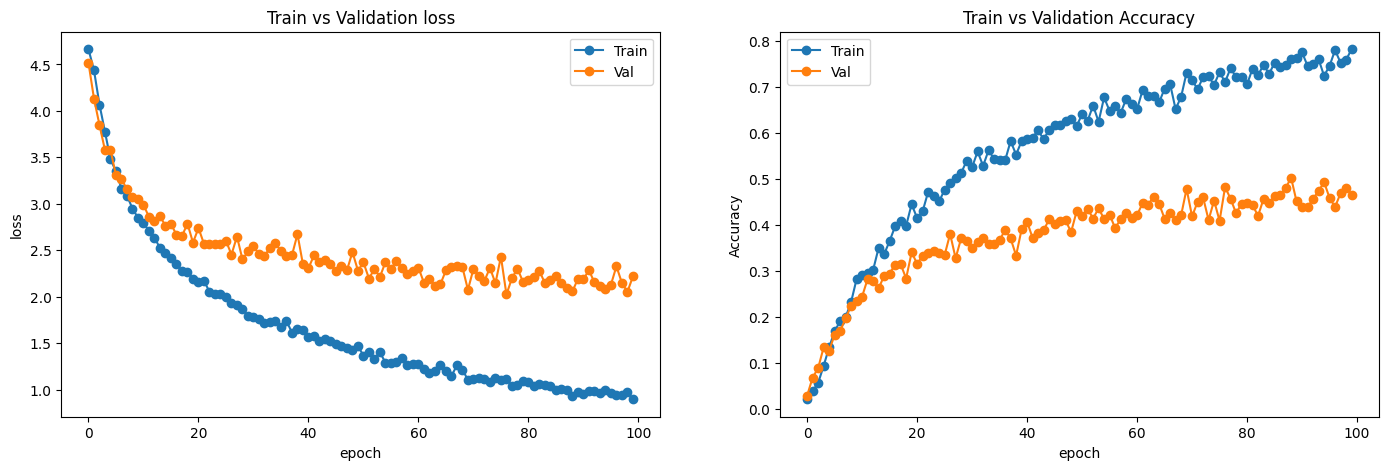

In [3]:
histVik = {'train_loss': [4.664371766149998, 4.436894081532955, 4.068456087261438, 3.773402977734804, 3.4786356948316097, 3.349734451621771, 3.1632076278328896, 3.0870689786970615, 2.9478161595761776, 2.849320273846388, 2.796988356858492, 2.7057560309767723, 2.6346807442605495, 2.523567520081997, 2.4669443629682064, 2.4166837260127068, 2.3488407265394926, 2.273570343852043, 2.267249211668968, 2.194144755601883, 2.15550385043025, 2.1713611483573914, 2.052516259253025, 2.0320266894996166, 2.026405803859234, 1.9973211996257305, 1.9325159154832363, 1.9113176204264164, 1.8691838160157204, 1.78892070800066, 1.780355153605342, 1.761245271191001, 1.7155639175325632, 1.7273050053045154, 1.739246191456914, 1.66824940033257, 1.7381227631121874, 1.6134111136198044, 1.6508939508348703, 1.6408607382327318, 1.5680519957095385, 1.5781198982149363, 1.5187966423109174, 1.5413911510258913, 1.5219615027308464, 1.4938958389684558, 1.469566147774458, 1.443269339390099, 1.4253616761416197, 1.4672602768987417, 1.3661950314417481, 1.408450952731073, 1.332720272243023, 1.398719866760075, 1.2907750643789768, 1.2874154737219214, 1.2994317337870598, 1.3424844099208713, 1.2645458653569221, 1.2707303818315268, 1.279487662948668, 1.223166131414473, 1.1803388521075249, 1.1968783820047975, 1.260618848260492, 1.1964825624600053, 1.146088880021125, 1.260292631573975, 1.2133332220837474, 1.103601791895926, 1.1134956404566765, 1.1270411452278495, 1.1107542449608445, 1.0774885658174753, 1.1237041829153895, 1.1065236134454608, 1.1147747049108148, 1.0369914453476667, 1.0527037689462304, 1.0871067624539137, 1.0805481215938926, 1.0362304178997874, 1.0619277795776725, 1.0476599056273699, 1.0421217670664191, 0.994933960493654, 1.00475550070405, 0.9970717956312001, 0.9327627061866224, 0.9742039144039154, 0.9539452316239476, 0.9814084758982062, 0.9884268185123801, 0.9601081628352404, 0.9928125268779695, 0.9621194833889604, 0.9362842845730484, 0.9438197971321642, 0.9687585956417024, 0.895611070562154], 'train_accuracy': [0.020588235294117647, 0.03823529411764706, 0.05588235294117647, 0.09313725490196079, 0.13333333333333333, 0.16862745098039217, 0.19019607843137254, 0.19901960784313724, 0.2323529411764706, 0.2823529411764706, 0.2911764705882353, 0.2950980392156863, 0.30196078431372547, 0.35, 0.3362745098039216, 0.36470588235294116, 0.39705882352941174, 0.40784313725490196, 0.3980392156862745, 0.44509803921568625, 0.4147058823529412, 0.4294117647058823, 0.4715686274509804, 0.46372549019607845, 0.45098039215686275, 0.4764705882352941, 0.49117647058823527, 0.5029411764705882, 0.5127450980392156, 0.5392156862745098, 0.5254901960784314, 0.5598039215686275, 0.5284313725490196, 0.5627450980392157, 0.5431372549019607, 0.5411764705882353, 0.5401960784313725, 0.5823529411764706, 0.5529411764705883, 0.5823529411764706, 0.5862745098039216, 0.5901960784313726, 0.6058823529411764, 0.5862745098039216, 0.6068627450980392, 0.6176470588235294, 0.6166666666666667, 0.6254901960784314, 0.6313725490196078, 0.6147058823529412, 0.6411764705882353, 0.6264705882352941, 0.6598039215686274, 0.6245098039215686, 0.6774509803921569, 0.6480392156862745, 0.6588235294117647, 0.6431372549019608, 0.6735294117647059, 0.6637254901960784, 0.6519607843137255, 0.6931372549019608, 0.6803921568627451, 0.6803921568627451, 0.6666666666666666, 0.696078431372549, 0.7068627450980393, 0.6519607843137255, 0.6784313725490196, 0.7313725490196078, 0.7156862745098039, 0.6950980392156862, 0.7215686274509804, 0.7235294117647059, 0.7049019607843138, 0.7323529411764705, 0.7107843137254902, 0.7411764705882353, 0.7215686274509804, 0.7225490196078431, 0.7058823529411765, 0.7401960784313726, 0.7254901960784313, 0.7490196078431373, 0.7284313725490196, 0.7529411764705882, 0.7441176470588236, 0.7470588235294118, 0.7607843137254902, 0.7637254901960784, 0.7754901960784314, 0.746078431372549, 0.7509803921568627, 0.7607843137254902, 0.7245098039215686, 0.746078431372549, 0.7803921568627451, 0.7529411764705882, 0.7588235294117647, 0.7823529411764706], 'val_loss': [4.516091629862785, 4.132196266204119, 3.847811698913574, 3.5761981438845396, 3.5786741320043802, 3.3057489590719342, 3.2691044751554728, 3.1539204213768244, 3.069784676656127, 3.0551942624151707, 2.9901552693918347, 2.8569942861795425, 2.8176592430099845, 2.868277125991881, 2.7613530391827226, 2.7818299662321806, 2.66698254738003, 2.653385809622705, 2.7866667984053493, 2.5816916516050696, 2.739255568012595, 2.5685817464254797, 2.5672891628928483, 2.571603326126933, 2.5705230375751853, 2.6017195330932736, 2.452428282238543, 2.6477533197030425, 2.400138066150248, 2.4890415298286825, 2.542079122038558, 2.457846191711724, 2.437503038905561, 2.5277577647939324, 2.576319026760757, 2.488521442981437, 2.4327838295139372, 2.4466205812059343, 2.6723895873874426, 2.347377099096775, 2.3068576308432966, 2.443847602698952, 2.3695878610014915, 2.398596952902153, 2.355066721793264, 2.271709634922445, 2.3303710278123617, 2.2837646529078484, 2.480730388779193, 2.280158568173647, 2.36856502154842, 2.195212979335338, 2.2979789059609175, 2.2133005153154954, 2.372309166006744, 2.2996453032828867, 2.3832599772140384, 2.3045230384450406, 2.246272223070264, 2.276823900640011, 2.312796250451356, 2.1491309572011232, 2.1895514959469438, 2.1188839827664196, 2.1349343759939075, 2.283868921920657, 2.318455784348771, 2.330991312628612, 2.3154154864605516, 2.0740722003392875, 2.2992920565302484, 2.2212749796453863, 2.169636088423431, 2.3109389855526388, 2.1441407662350684, 2.430483258329332, 2.023404924897477, 2.1984779946506023, 2.302355580846779, 2.161799199413508, 2.183432149933651, 2.2087724548764527, 2.2789928147103637, 2.1434608045965433, 2.1812252388335764, 2.222069764044136, 2.1514393942197785, 2.093285182258114, 2.0560299286153167, 2.192651556339115, 2.187483297660947, 2.285249412059784, 2.1534811900928617, 2.1197051235940307, 2.085051271598786, 2.128298240713775, 2.326959717553109, 2.1477927232626826, 2.051528320997022, 2.217643146868795], 'val_accuracy': [0.028431372549019607, 0.06764705882352941, 0.08823529411764706, 0.13333333333333333, 0.1264705882352941, 0.1607843137254902, 0.16862745098039217, 0.19705882352941176, 0.2235294117647059, 0.23431372549019608, 0.24411764705882352, 0.2823529411764706, 0.2774509803921569, 0.26176470588235295, 0.28921568627450983, 0.29411764705882354, 0.3137254901960784, 0.31470588235294117, 0.2833333333333333, 0.34019607843137256, 0.3156862745098039, 0.3323529411764706, 0.3392156862745098, 0.3431372549019608, 0.3382352941176471, 0.33431372549019606, 0.3803921568627451, 0.32745098039215687, 0.37058823529411766, 0.36470588235294116, 0.35, 0.3627450980392157, 0.37254901960784315, 0.35784313725490197, 0.3588235294117647, 0.36666666666666664, 0.3892156862745098, 0.37058823529411766, 0.3333333333333333, 0.39019607843137255, 0.4068627450980392, 0.3715686274509804, 0.3813725490196078, 0.38823529411764707, 0.4117647058823529, 0.40294117647058825, 0.40784313725490196, 0.40980392156862744, 0.3843137254901961, 0.4294117647058823, 0.4196078431372549, 0.43529411764705883, 0.4137254901960784, 0.4362745098039216, 0.41274509803921566, 0.42254901960784313, 0.3931372549019608, 0.4117647058823529, 0.42549019607843136, 0.4147058823529412, 0.4215686274509804, 0.4470588235294118, 0.44313725490196076, 0.46176470588235297, 0.44607843137254904, 0.4137254901960784, 0.42549019607843136, 0.4107843137254902, 0.42058823529411765, 0.47843137254901963, 0.41862745098039217, 0.45, 0.4598039215686274, 0.4107843137254902, 0.45294117647058824, 0.4088235294117647, 0.4823529411764706, 0.4568627450980392, 0.42549019607843136, 0.44607843137254904, 0.4470588235294118, 0.44313725490196076, 0.4196078431372549, 0.4568627450980392, 0.44803921568627453, 0.4627450980392157, 0.46568627450980393, 0.47941176470588237, 0.5029411764705882, 0.45098039215686275, 0.4392156862745098, 0.43823529411764706, 0.4568627450980392, 0.47352941176470587, 0.4931372549019608, 0.4588235294117647, 0.4392156862745098, 0.46862745098039216, 0.4803921568627451, 0.46568627450980393]}
pltHist(histVik)